In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, confusion_matrix
import os
import random
import gc

In [42]:
seed = 42
random.seed(seed)
np.random.seed(seed)

In [44]:
# Define the Attention Layer
class Attention(nn.Module):
    def __init__(self, shape):
        super(Attention, self).__init__()
        self.attention_dense = nn.Linear(shape, shape)
    
    def forward(self, inputs):
        # Apply linear transformation
        a = self.attention_dense(inputs)
        # Apply softmax to get attention scores
        attention_scores = F.softmax(a, dim=-1)
        # Element-wise multiplication with inputs
        output_attention_mul = inputs * attention_scores
        return output_attention_mul, attention_scores

# Define the Model
class CustomModel_attext(nn.Module):
    def __init__(self, n_wind, n_features, dense_nparams1=128):
        super(CustomModel_attext, self).__init__()
        self.attention = Attention(n_features)
        self.lstm = nn.LSTM(n_features, dense_nparams1, num_layers=1, batch_first=True)
        self.dense = nn.Linear(dense_nparams1, 1)
    
    def forward(self, x, return_attention=False):
        # Get the attended output and attention scores
        x, attention_scores = self.attention(x)
        # Pass through LSTM
        x, _ = self.lstm(x)
        # Extract the last output of the LSTM
        x = x[:, -1, :]
        # Apply the dense layer with sigmoid activation
        x = torch.sigmoid(self.dense(x))
        
        if return_attention:
            return x, attention_scores
        return x

## load test data

In [45]:
dtest = torch.load('Mortality/Mtest.pt')
ytest = torch.load('Mortality/y_test.pt')

In [46]:
dtest.shape, ytest.shape

(torch.Size([2231, 288, 231]), torch.Size([2231]))

In [47]:
adverse_indices = torch.where(ytest == 1)[0]

In [48]:
adverse_indices, adverse_indices.shape

(tensor([   7,   24,   25,   60,   72,   73,   86,   98,  107,  110,  122,  146,
          159,  164,  180,  197,  206,  207,  209,  220,  229,  231,  248,  255,
          269,  296,  303,  325,  368,  382,  387,  399,  427,  455,  465,  468,
          504,  515,  533,  565,  579,  584,  593,  611,  616,  637,  640,  655,
          670,  671,  678,  689,  705,  712,  724,  730,  736,  755,  758,  771,
          773,  778,  792,  823,  829,  838,  851,  870,  874,  876,  878,  895,
          896,  926,  942,  948,  961,  994, 1010, 1030, 1055, 1060, 1074, 1093,
         1099, 1117, 1131, 1143, 1160, 1165, 1179, 1191, 1195, 1203, 1208, 1213,
         1214, 1220, 1228, 1232, 1235, 1251, 1269, 1280, 1283, 1287, 1311, 1329,
         1340, 1347, 1348, 1360, 1379, 1380, 1387, 1394, 1397, 1412, 1423, 1428,
         1461, 1486, 1489, 1493, 1494, 1495, 1503, 1510, 1514, 1554, 1555, 1570,
         1582, 1613, 1652, 1655, 1679, 1684, 1687, 1696, 1697, 1717, 1725, 1737,
         1761, 1771, 1782, 1

In [49]:
dtest1394 = dtest.numpy()[1394]

In [50]:
# model = CustomModel(288, 231)
model = CustomModel_attext(288, 231)

In [ ]:
## good model = 350, 356, 968

## load weights

In [320]:
model.load_state_dict(torch.load("model_checkpoints/mortality/models/bm_roc_seed_350.pth"))
# model.load_state_dict(torch.load("model_checkpoints/mortality/models/bm_roc_seed_356.pth"))
# model.load_state_dict(torch.load("model_checkpoints/mortality/models/bm_roc_seed_968.pth"))
model.eval()  # Set the model to evaluation mode

CustomModel_attext(
  (attention): Attention(
    (attention_dense): Linear(in_features=231, out_features=231, bias=True)
  )
  (lstm): LSTM(231, 128, batch_first=True)
  (dense): Linear(in_features=128, out_features=1, bias=True)
)

### predict on loaded model

In [158]:
model = model.cuda(0)

In [159]:
# Run the model and make a prediction with attention scores
dtest1394_tensor = torch.tensor(dtest1394).unsqueeze(0).cuda(0)

In [160]:
with torch.no_grad():
    pred1394, attention_scores = model(dtest1394_tensor, return_attention=True)
    pred1394 = pred1394.item()
    attention_scores = attention_scores.squeeze().detach().cpu().numpy()

In [161]:
pred1394, attention_scores.shape

(0.9815675616264343, (288, 231))

In [155]:
# for i in range(100,1000):
#     # path = 'model_checkpoints/mortality/models/bm_roc_seed_00'+str(i)+'.pth'
#     # path = 'model_checkpoints/mortality/models/bm_roc_seed_0'+str(i)+'.pth'
#     path = 'model_checkpoints/mortality/models/bm_roc_seed_'+str(i)+'.pth'
#     # print(path)
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     model = model.cuda(0)
#     with torch.no_grad():
#         pred1394, attention_scores = model(dtest1394_tensor, return_attention=True)
#         pred1394 = pred1394.item()
#         attention_scores = attention_scores.squeeze().detach().cpu().numpy()
#     if pred1394 > 0.92:
#         print(i,pred1394)

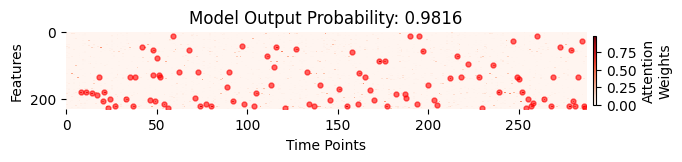

In [162]:
att_scores = attention_scores
fig, ax = plt.subplots(1, 1, figsize=(8, 1))

# Define the number of top values to highlight
num_top_values = 100 #500

# Find the indices of the top N values
flat_indices = np.argsort(att_scores.T, axis=None)[-num_top_values:]
top_indices = np.unravel_index(flat_indices, att_scores.T.shape)

im = plt.imshow(att_scores.T, cmap='Reds', aspect='auto', interpolation='nearest')
plt.title(f'Model Output Probability: {round(pred1394,4)}')
plt.xlabel("Time Points")
plt.ylabel("Features")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
fig.colorbar(im, ax=ax, 
             # location = 'right',
             # orientation='horizontal',
             # fraction=0.9,
             # aspect=2,
             pad=0.01,
             # bbox_to_anchor=(0.1,0,1,1),
             shrink=0.9,
             # anchor=(0.5, 0.5),
            ).set_label('Attention\nWeights', fontsize=10)

plt.scatter(top_indices[1], top_indices[0], color='r', marker='.', s=50, label='Top 100\nAttention Scores',alpha=0.6)
# ax.legend(bbox_to_anchor=(1.0, 1.02))
# plt.show()
plt.savefig('Figure4c.png', dpi=400, bbox_inches='tight')

In [349]:
modeldir = sorted(os.listdir('model_checkpoints/mortality/models'))

In [350]:
len(modeldir)

1000

In [138]:
model

CustomModel(
  (attention): Attention(
    (attention_dense): Linear(in_features=231, out_features=231, bias=True)
  )
  (lstm): LSTM(231, 128, batch_first=True)
  (dense): Linear(in_features=128, out_features=1, bias=True)
)

In [140]:
pred7 = model(torch.tensor(dtest7).unsqueeze(0).cuda(0)).item()

In [141]:
pred7

0.6788225173950195

### model analysis

In [336]:
# model.load_state_dict(torch.load("model_checkpoints/mortality/models/bm_roc_seed_350.pth"))
# model.load_state_dict(torch.load("model_checkpoints/mortality/models/bm_roc_seed_356.pth"))
model.load_state_dict(torch.load("model_checkpoints/mortality/models/bm_roc_seed_968.pth"))
# model.eval() 

<All keys matched successfully>

In [337]:
weight_matrix = model.attention.attention_dense.weight.data
wmnp = weight_matrix.detach().cpu().numpy()

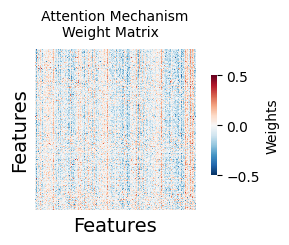

In [339]:
ax = sns.clustermap(wmnp, annot=False, cmap='RdBu_r', cbar=True, method='ward',
               dendrogram_ratio=(0.05, 0.05),
                    vmax=0.5,
                    vmin=-0.5,
                    cbar_kws={"shrink": 0.75, "label": "Weights"},
            # xticklabels=feature_names, yticklabels=feature_names, linewidths=0.5
               figsize=(2, 2),
            row_cluster=False,
            col_cluster=False,
                cbar_pos=(1.0, .25, .03, .5),
                    xticklabels=False,
                    yticklabels=False
           )
plt.suptitle('   Attention Mechanism \nWeight Matrix', fontsize=10, y=1.08)
ax.ax_heatmap.set_xlabel("Features", fontsize=14)
ax.ax_heatmap.yaxis.set_label_position('left') 
ax.ax_heatmap.set_ylabel("Features", fontsize=14)
# plt.show()
plt.savefig('Figure5c.png', dpi=400, bbox_inches='tight')

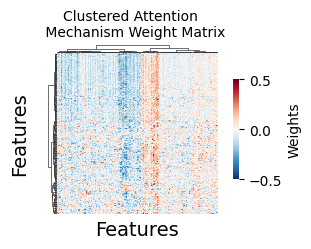

In [338]:
ax = sns.clustermap(wmnp, annot=False, cmap='RdBu_r', cbar=True, method='ward',
               dendrogram_ratio=(0.05, 0.05),
                    cbar_kws={"shrink": 0.75, "label": "Weights"},
                    vmax=0.5,
                    vmin=-0.5,
            # xticklabels=feature_names, yticklabels=feature_names, linewidths=0.5
               figsize=(2, 2),
            # row_cluster=False  # Only cluster columns
                cbar_pos=(1.0, .25, .03, .5),
                    xticklabels=False,
                    yticklabels=False
           )

ax.ax_heatmap.set_xlabel("Features", fontsize=14)
ax.ax_heatmap.yaxis.set_label_position('left')
ax.ax_heatmap.set_ylabel("Features", fontsize=14,labelpad=20)
# ax.tick_params(left=False, bottom=False) ## other options are right and top
# plt.title('Attention Weights Clustered')
# plt.xlabel("Timesteps")
# plt.ylabel("Timesteps")
# plt.axis('off')
plt.suptitle('Clustered Attention \n Mechanism Weight Matrix', fontsize=10, y=1.10)
# plt.show()
plt.savefig('Figure5f.png', dpi=400, bbox_inches='tight')

## Attention drop analysis

In [304]:
def cudrop(num_model, topk, pid):

    pred_list = []
    topk_list = []
    
    indices = list(range(num_model))

    # Shuffle the list in place
    random.shuffle(indices)
    
    for i in indices:
        modelfile = modeldir[i]
        model = CustomModel_attext(288,231)
        model.load_state_dict(torch.load(f'model_checkpoints/mortality/models/{modelfile}'))
        model.eval()  # Set the model to evaluation mode
        model = model.cuda(0)
        dtestp = dtest.numpy()[pid]
        dtestp_tensor = torch.tensor(dtestp).unsqueeze(0).cuda(0)
        with torch.no_grad():
            predp, attention_scores = model(dtestp_tensor, return_attention=True)
            predp = predp.item()
            att_scores = attention_scores.squeeze().detach().cpu().numpy()

        pred_list.append(round(predp,4))

        # Define the number of top values to highlight
        num_top_values = topk #500

        # Find the indices of the top N values
        flat_indices = np.argsort(att_scores.T, axis=None)[-num_top_values:]
        top_indices = np.unravel_index(flat_indices, att_scores.T.shape)

        topk_list.append(top_indices)
        
        
    running_means = []
    running_sum = 0

    # Calculate running mean for each value in the values list
    for i, value in enumerate(pred_list):
        running_sum += value
        running_mean = running_sum / (i + 1)
        running_means.append(round(running_mean, 4))  # Restrict to 4 decimal places
        
        
    cumulative_matrix = np.ones((231, 288), dtype=int)  # Ensure correct matrix size
    cl_list = []
    # Iterate through each set of top_indices tuples (10 runs)
    for i, top_indices in enumerate(topk_list):
        # Initialize a 2D matrix with zeros for the current run
        matrix = np.zeros((231, 288), dtype=int)  # Ensure correct matrix size

        # Fill the matrix with 1s at the positions specified by the coordinates
        for y, x in zip(top_indices[0], top_indices[1]):
            matrix[y, x] = 1

        # Perform an element-wise logical AND with the cumulative matrix
        cumulative_matrix = np.logical_and(cumulative_matrix, matrix)

        cl_list.append(np.sum(cumulative_matrix))
        
        
    return cl_list, list(range(len(cl_list))), pred_list, running_means

### for all patients

In [369]:
adverse_list = adverse_indices.numpy().tolist()

In [383]:
list100  = []
list1000 = []
list10000= []

for i in tqdm(adverse_list):
    list100.append(cudrop(1000, 100, i))
    list1000.append(cudrop(1000, 1000, i))
    list10000.append(cudrop(1000, 10000, i))

In [2]:
import pickle

In [387]:
# List comprehension to separate even and odd index elements
list1k_temp = [list1000[i] for i in range(len(list1000)) if i % 2 == 0]  # Elements at even indices
list10k_temp = [list1000[i] for i in range(len(list1000)) if i % 2 != 0]   # Elements at odd indices

In [436]:
list1k = list1k_temp
list10k = list10k_temp

In [437]:
len(list100), len(list1k), len(list10k)

(186, 186, 186)

In [391]:
# # Save the list to a pickle file
# with open('cudrop_1000m_100f.pkl', 'wb') as file:  # Open file in binary write mode
#     pickle.dump(list100, file)
    
# # Save the list to a pickle file
# with open('cudrop_1000m_1000f.pkl', 'wb') as file:  # Open file in binary write mode
#     pickle.dump(list1k_temp, file)
    
# # Save the list to a pickle file
# with open('cudrop_1000m_10000f.pkl', 'wb') as file:  # Open file in binary write mode
#     pickle.dump(lis10k_temp, file)

In [3]:
# Load the list from the first pickle file
with open('cudrop_1000m_100f.pkl', 'rb') as file:  # Open file in binary read mode
    list100 = pickle.load(file)

# Load the list from the second pickle file
with open('cudrop_1000m_1000f.pkl', 'rb') as file:  # Open file in binary read mode
    list1k = pickle.load(file)

# Load the list from the third pickle file
with open('cudrop_1000m_10000f.pkl', 'rb') as file:  # Open file in binary read mode
    list10k = pickle.load(file)

In [4]:
list100_mean     = np.mean(np.array([item[0] for item  in list100]),axis=0).tolist()
list1k_mean      = np.mean(np.array([item[0] for item  in list1k]),axis=0).tolist()
list10k_mean     = np.mean(np.array([item[0] for item  in list10k]),axis=0).tolist()

In [5]:
len(list100_mean), len(list1k_mean), len(list10k_mean)

(1000, 1000, 1000)

In [6]:
import matplotlib.ticker as ticker

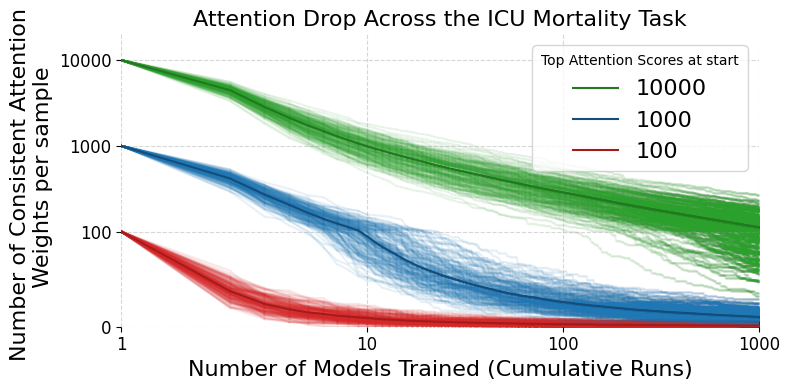

In [12]:
# Create the scatter plot
fig, ax = plt.subplots(1, 1, figsize=(8, 4)) # Set figure size for better clarity
###################################################################################################### for 10000 top features


for item in list100:
    tlist = [ditem+1 for ditem in item[1]]
    plt.scatter(tlist, item[0], color='#d62728', marker='o', s=1, alpha=0.01)
    plt.plot(tlist, item[0], color='#d62728',alpha=0.1)
    

for item in list1k:
    # tlist = [ditem+1 for ditem in item[1]]
    plt.scatter(tlist, item[0], color='#1f77b4', marker='o', s=1, alpha=0.01)
    plt.plot(tlist, item[0], color='#1f77b4',alpha=0.1)
    
    
for item in list10k:
    # tlist = [ditem+1 for ditem in item[1]]
    plt.scatter(tlist, item[0], color='#2ca02c', marker='o', s=1, alpha=0.01)
    plt.plot(tlist, item[0], color='#2ca02c',alpha=0.1)    

############################################################################################### 

plt.scatter(tlist, list100_mean, color='#a31c1c', marker='.', s=2, alpha=1.0)
plt.plot(tlist, list100_mean, color='#a31c1c',alpha=1.0, label='100')

plt.scatter(tlist, list1k_mean, color='#154c7a', marker='.', s=2, alpha=1.0)
plt.plot(tlist, list1k_mean, color='#154c7a',alpha=1.0, label='1000')

plt.scatter(tlist, list10k_mean, color='#217821', marker='.', s=2, alpha=1.0)
plt.plot(tlist, list10k_mean, color='#217821',alpha=1.0,label='10000')

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Add labels and title with enhanced font size
plt.xlabel('Number of Models Trained (Cumulative Runs)', fontsize=16)
plt.ylabel('Number of Consistent Attention \n Weights per sample', fontsize=16)
plt.title('Attention Drop Across the ICU Mortality Task', fontsize=16, 
          # weight='bold'
         )

# Enhance ticks for better readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('symlog', 
           linthresh=100
          )
# plt.yscale('asinh', linthresh=10)
plt.xscale('symlog', 
           # linthresh=10
          )
# plt.xscale('asinh')

plt.ylim(0,20000)
plt.xlim(1,1001)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# Display the plot
# Reversing the order of the legend items
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='upper right', fontsize=16, title='Top Attention Scores at start')  # Reversing handles and labels
# Use ScalarFormatter for the x-axis
formatter = ticker.ScalarFormatter(useOffset=False)
formatter.set_scientific(False)
plt.gca().xaxis.set_major_formatter(formatter)
# # Define a custom formatter to shift x-axis labels by +1
# def shift_labels(x, pos):
#     return int(x) + 1

# plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(shift_labels))
# Use ScalarFormatter for the y-axis (optional)
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()  # Adjust layout to make sure everything fits nicely
# plt.show()
# Save the plot with high resolution
plt.savefig('Figure2.png', dpi=600, bbox_inches='tight')